## Simulating and AFM Cantilever response in Python

The simulation code integrates the ordinary differential equation describing an AFM cantilever's motion. That, by itself, is not particularly interesting as it's just an exercise for undergraduates in physics courses. What IS interesting, is adding some sort of transient excitation and seeing the response.

The simulation code in **FFTA** pacakage allows for an excitation voltage to be applied at some particular point in time and therefore affects the cantilever's motion. More specifically, this simulation applies a shift in the resonance frequenecy with some time constant and an electrostatic force that changes with the same time constant. Here, that time-dependent response is an exponential decay (1-exp(-t/tau))

A secondary option is to apply an electric drive to the cantilever to see second resonance responses, but that is outside the scope of this notebook.

Much of this is used in the following publication:
Karatay DU, Harrison JA, et al. Fast time-resolved electrostatic force microscopy: Achieving sub-cycle time resolution. *Rev Sci Inst.* **87,** 053702 (2016). [DOI: 10.1063/1.4948396](http://dx.doi.org/10.1063/1.4948396)

In [1]:
import ffta
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np

In [2]:
# Specify our configuration file
path = r'G:\My Drive\Durmus_Backup\Simulations\PhaseEffectSim\Parameters\300kHz_simulation.cfg'

### The configuration file

The configuration if usually some .cfg file on the disk. Typically it has a form like this:

```
[Cantilever Parameters]
amp_invols = 5.52e-08       ;in m/V.
def_invols = 5.06e-08       ;in m/V.
soft_amp = 0.3              ;in m/V
drive_freq = 272244.5       ;in Hz.
res_freq = 272218.4         ;in m.
k = 26.2                    ;in N/m.
q_factor = 432

[Force Parameters]
es_force = 4e-9             ;in N.
delta_freq = -170           ;in Hz.
tau = 10e-9                 ;in seconds.

[Simulation Parameters]
trigger = 16384e-7          ;in seconds.
total_time = 32768e-7       ;in seconds.
sampling_rate = 1e7         ;in Hz.
```

Other possible parameters for the Force are 
* dC/dz (a typical value of 1e-10 F/m is fine
* V_cpd, V_dc, V_ac : voltages that describe the electric drive signal

Currently there's no way to simply supply a drive signal as might be recorded in an experiment, but that will be added

Let's go through what some of these parameters mean:

```
amp_invols: 
    Amplitude inverted optical lever sensitivity, converts amplitude from Volts to meters
def_invols: 
    Defletion inverted optical level sensitivity, converts the deflection from Volts to meters.

soft_amp: 
    "Soft amplitude" which is just an archaic way of saying cantilever amplitude during EFM
drive_freq and res_freq: 
    The driving frequency and resonance frequency of the cantilever
k: 
    spring constant
q_factor: 
    Quality factor of the cantilever (i.e. FWHM of the tune curve peak

es_force: 
    Electrostatic force. This value is measured experimentally by applying a voltage and measuring the deflection (using Hooke's Law F = -kz)
delta_freq: 
    When shifting the resonance frequency, this is how much to shift it by
tau: 
    time constant for the exponential function applied to the cantilever.

trigger: 
    When during the simulation to apply a change in the resonance frequency
total_time: 
    Total time to integrate for
sampling_rate: 
    This is only used to have the simulation match the experiment. The experiment is often at 1e7 Hz (10 MHz). The simulation is currently hard-coded at 100 MHz then down-sampled at the end.
```

##### What does that mean?

In our simulation the resonance frequency is changed at some point in time. In the config file this is "trigger_time" and the total length of the simulation is "total_time." So, for a cantilever where **total_time** = 1 ms, and **trigger** = 0.5 ms, then at 0.5 ms the resonance frequency is shifted by an amount **delta_freq**, with the rate of the shift controlled by **tau**

#### The next step is load the configuration file

This next line creates three dictionaries corresponding to the three sections above. 

In [3]:
can_params, force_params, sim_params = ffta.simulation.load.simulation_configuration(path)

### Create the cantilever object

In the next cell, we create the Cantilever object:
```
cant = ffta.simulation.simulate.Cantilever(can_params, force_params, sim_params)
```

This creates "cant" which is an object of the class "Cantilever." Note that you could be a little more readable and say

```
params = ffta.simulation.load.simulation_configuration(path)
cant =  ffta.simulation.simulate.Cantilever(*params)
```

...but that's a style choice.

Anyway, now that we have our Cantilever object, we can simulate it.

In [5]:
cant = ffta.simulation.simulate.Cantilever(can_params, force_params, sim_params)

#### The next step is simulate the cantilever

The simulation can take one of two parameters:

```
trigger_phase: float, optional
    Trigger phase is in degrees and with respect to cosine. Default value is 180.
Z0 : list, optional
    Z0 = [z0, v0], the initial position and velocity
    If not specified, is calculated from the analytical solution to DDHO (using class function "set_conditions")
```

**Trigger_phase** controls the phase of the cantilever when the excitation is applied. In our paper on this subject, we found that the phase does matter; if the cantilever is at some random phase relative to the excitation, you can lose time-resolution. Practically speaking, this effect is not all that important except at very fast timescales. 

The cantilever, prior to ODE integration, will try and set the initial conditions for the differential equation. That is, it will try and set Z(0) and v(0), the initial position and velocity for time t=0. The default is to set them such that the cantilever is at steady-state conditions for t=0, avoiding any wasted simulation time.

**Z0** Instead of defaulting, you can set the initial conditions explicitly. This parameter is useful for electrically-driven cantilevers where the solution to the DDHO is not well known.

In [9]:
# Run the simulation!
Z, info = cant.simulate()

### Plot the results

Now that we have our simulation, let's see what it looks like. Note that Z is rescaled to Volts to match an experiment, but you can multiply by *cant.def_invols*

Text(0.5, 1.0, 'Simulation')

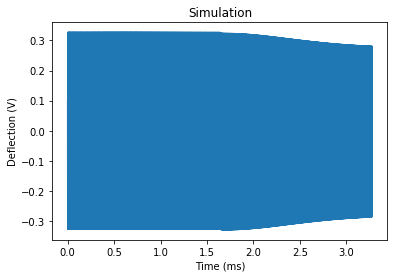

In [21]:
plt.plot(cant.t_Z * 1e3, Z)
plt.xlabel('Time (ms)')
plt.ylabel('Deflection (V)')
plt.title('Simulation')

As you can see, the cantilever is going well, then at halfway there's a change due to an exponential voltage pulse with time constant 10 ns. Let's see what happens if we change the initial conditions.

Text(0.5, 1.0, 'Simulation with initial conditions 0 m, 0 m/s')

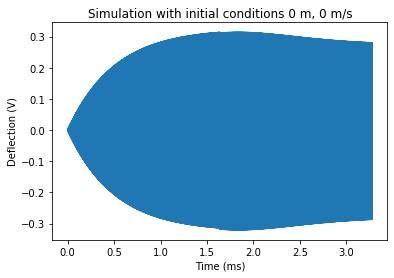

In [17]:
Z, info = cant.simulate(Z0 = [0,0])
plt.plot(cant.t_Z * 1e3, Z)
plt.xlabel('Time (ms)')
plt.ylabel('Deflection (V)')
plt.title('Simulation with initial conditions 0 m, 0 m/s')

##### What happened? 
Well, because we specified the cantilever to be at rest at time t=0 (Z0 = [0,0]), the cantilever had to oscillate for awhile before it settled at its steady-state condition. This initial part of the simulation is not all that useful, and it just wastes time, so we set the initial conditions. 

Now, what if we change up some of the parameters? Let's try a different time constant, maybe of 1e-3 s (1 ms).

Text(0.5, 0, 'Time (ms)')

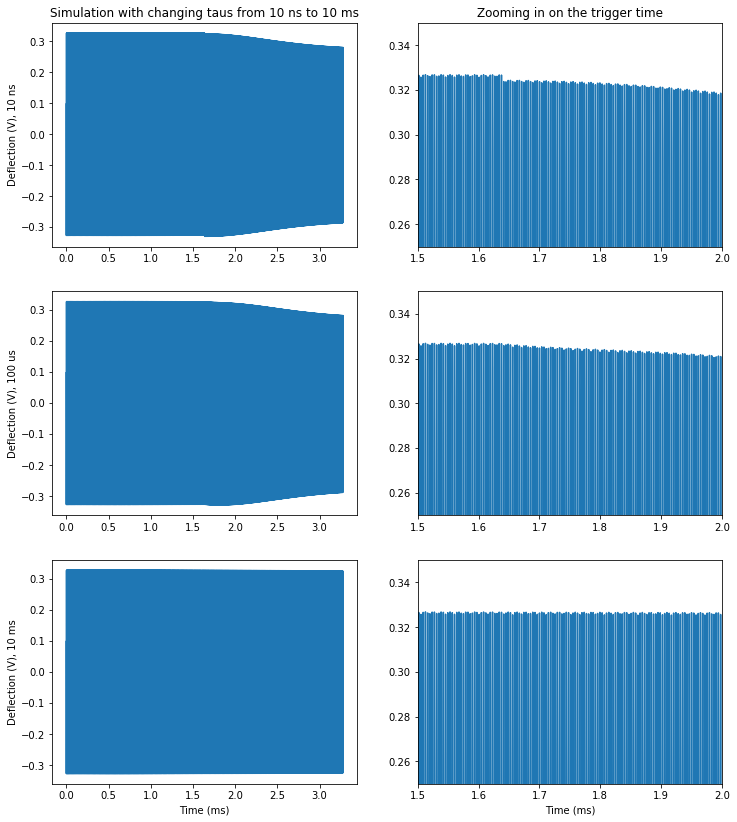

In [32]:
fig, a = plt.subplots(nrows=3, ncols = 2, figsize=(12,14))

cant.tau = 1e-8
Z, info = cant.simulate()
a[0][0].plot(cant.t_Z * 1e3, Z)
a[0][1].plot(cant.t_Z * 1e3, Z)
a[0][0].set_ylabel('Deflection (V), 10 ns')
a[0][0].set_title('Simulation with changing taus from 10 ns to 10 ms')
a[0][1].set_title('Zooming in on the trigger time')
a[0][1].set_xlim(1.5, 2)
a[0][1].set_ylim(0.25, 0.35)

cant.tau = 1e-4
Z, info = cant.simulate()
a[1][0].plot(cant.t_Z * 1e3, Z)
a[1][1].plot(cant.t_Z * 1e3, Z)
a[1][0].set_ylabel('Deflection (V), 100 us')
a[1][1].set_xlim(1.5, 2)
a[1][1].set_ylim(0.25, 0.35)

cant.tau = 1e-2
Z, info = cant.simulate()
a[2][0].plot(cant.t_Z * 1e3, Z)
a[2][1].plot(cant.t_Z * 1e3, Z)
a[2][0].set_ylabel('Deflection (V), 10 ms')
a[2][1].set_xlim(1.5, 2)
a[2][1].set_ylim(0.25, 0.35)

a[2][0].set_xlabel('Time (ms)')
a[2][1].set_xlabel('Time (ms)')

##### What happened? 
Here, we are changing how quickly the resonance frequency changes. In the 10 ns and 100 us case, the cantilever looks similar. However, the key is what's happening at the trigger time. For the 10 ns case, there's a sharp change at the trigger (~1.6 ms). For the 100 us case, it's a slow change. For the 10 ms case, there's barely any change. 

That means the interesting dynamics are in this region of the time window. The cantilevers in all three cases "relax" at about the same rate, because that is just dependent upon the cantilever Q factor for the most part, and it is unrelated to any transient effect. 

Finally, let's try changing the electrostatic force and the delta_freq (the amount of electrostatic force applied, i.e. the voltage, and the amount the resonance frequency shifts by). These values should normally not be changed independently as they're related to one another and are acquired during a measurement. But, just for fun, let's see what happens.

Text(0.5, 0, 'Time (ms)')

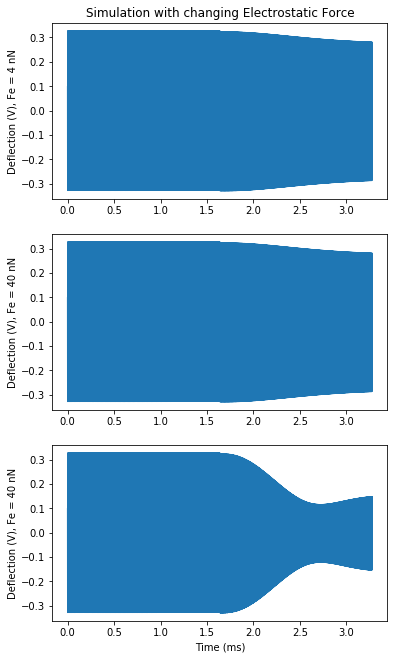

In [36]:
fig, a = plt.subplots(nrows=3, figsize=(6, 11))

cant.tau = 1e-6
cant.es_force = 4e-9 
cant.delta_freq = -170 # 600 Hz is a huge shift
cant.delta_w = 2* np.pi * cant.delta_freq # convert to radians
Z, info = cant.simulate()
a[0].plot(cant.t_Z * 1e3, Z)
a[0].set_ylabel('Deflection (V), Fe = 4 nN')
a[0].set_title('Simulation with changing Electrostatic Force')

cant.es_force = 4e-7 # 100 X the force
cant.delta_freq = -170 # 600 Hz is a huge shift
cant.delta_w = 2* np.pi * cant.delta_freq # convert to radians
Z, info = cant.simulate()
a[1].plot(cant.t_Z * 1e3, Z)
a[1].set_ylabel('Deflection (V), Fe = 40 nN')

cant.es_force = 4e-9 
cant.delta_freq = -600 # 600 Hz is a huge shift
cant.delta_w = 2* np.pi * cant.delta_freq # convert to radians
Z, info = cant.simulate()
a[2].plot(cant.t_Z * 1e3, Z)
a[2].set_ylabel('Deflection (V), Fe = 40 nN')
a[2].set_xlabel('Time (ms)')

As you can see, the Electrostatic Force alone doesn't do too much. The change in resonance frequency, though, changes a lot! This effect is because the change in resonance frequency changes the factors proportional to z and z' in the 